In [1]:
import os
import sys
sys.path.insert(0, '../MSA-HMM')
import msa_hmm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fasta_files = []
ref_fasta_files = []
train_path = "data/large/train/" 
refs_path = "data/large/refs/" 
for file in os.listdir(os.fsencode(train_path)):
    filename = os.fsdecode(file)
    if filename.endswith(".fasta"):
        fasta = msa_hmm.fasta.Fasta(train_path+filename, gaps=False, contains_lower_case=True)
        ref_fasta = msa_hmm.fasta.Fasta(refs_path+filename[:-6]+".ref", gaps=True, contains_lower_case=True)
        fasta_files.append(fasta)
        ref_fasta_files.append(ref_fasta)

In [3]:
for ref_fasta in ref_fasta_files:
    print(ref_fasta.num_seq)

62
1465
55
48
192
98
38
159
184
52


In [4]:
np.random.seed(94) 

num_samples = 10
subset_sizes = [int(i) for i in [1500, 1e4, 2e4, 5e4, 1e5, 2e5, 3e5, 5e5]]
      
def sample_subset(fasta, ref_fasta, old_indices, subset_size):
    assert subset_size < old_indices.size, "The sampled subset has to be smaller than the old subset."
    ref_indices = np.array([fasta.seq_ids.index(sid) for sid in ref_fasta.seq_ids])
    for i in ref_indices:
        assert np.where(old_indices == i)[0].size == 1, f"Ref. index {i} is either not at all or multiple times in the old indices array."
    homolog_indices = np.setdiff1d(old_indices, ref_indices)
    homolog_subset = np.random.choice(homolog_indices, size=subset_size-ref_indices.size, replace=False)
    return np.concatenate([ref_indices, homolog_subset], axis=0)
        
    
subsets = []
for fasta, ref_fasta in zip(fasta_files, ref_fasta_files):
    indices = [ [np.arange(fasta.num_seq) for _ in range(num_samples)] ]
    for size in reversed(subset_sizes):
        indices.append([])
        for ind in indices[-2]:
            subset = sample_subset(fasta, ref_fasta, ind, size)
            indices[-1].append(subset)
    subsets.append(indices[1:])

In [5]:
def make_paths(fasta, subset, k):
    filename = os.path.splitext(os.path.basename(fasta.filename))[0]
    subset_fasta_path = f"results/size_scaling/subset_fasta/{filename}_{subset.size}_{k}.fasta"
    out_filepath = f"results/size_scaling/subset_alignments/{filename}_{subset.size}_{k}.fasta"
    return subset_fasta_path, out_filepath
    

def gen_fasta(fasta, subset, k):
    subset_fasta_path, _ = make_paths(fasta, subset, k)
    with open(subset_fasta_path, "w") as subset_fasta:
        for i in subset:
            subset_fasta.write(">"+fasta.seq_ids[i]+"\n")
            subset_fasta.write(fasta.aminoacid_seq_str(i)+"\n")

def align_subset(fasta, subset, k):
    subset_fasta_path, out_filepath = make_paths(fasta, subset, k)
    if not os.path.exists(out_filepath):
        subset_fasta = msa_hmm.fasta.Fasta(subset_fasta_path, 
                                     gaps=False, 
                                     contains_lower_case=True)  
        results = msa_hmm.align.fit_and_align_n(subset_fasta, 
                                                num_runs=1,
                                                config=msa_hmm.config.default,
                                                subset=None)
        best = np.argmax([ll for ll,_ in results])
        best_ll, best_alignment = results[best]
        best_alignment.to_file(out_filepath)

In [ ]:
#generate sampled files 
for fasta, subsets_by_size in zip(fasta_files, subsets):
    for subset_by_size in subsets_by_size:
        for k, sample in enumerate(subset_by_size):
            gen_fasta(fasta, sample, k)

In [ ]:
#align them with learnMSA
for fasta, subsets_by_size in zip(fasta_files, subsets):
    for subset_by_size in subsets_by_size:
        for k, sample in enumerate(subset_by_size):
            align_subset(fasta, sample, k)

Training of 1 independent models on file PF07690.19_500000_0.fasta
Configuration:
transition_init : default , flank_init : default , emission_init : background
 , alpha_flank : 7000 , alpha_single : 1000000000.0 , alpha_frag : 10000.0
 , max_surgery_runs : 4 , length_init_quantile : 0.5 , surgery_quantile : 0.5
 , min_surgery_seqs : 10000.0 , len_mul : 0.8 , batch_size : adaptive
 , use_prior : True , dirichlet_mix_comp_count : 1 , use_anc_probs : True
 , tau_init : 0.0 , keep_tau : False
500000 sequences of max. length 544
Fitting a model of length 250 on 250000 sequences
Batch size= 256 Learning rate= 0.1
Using 2 GPUs.
Epoch 1/2
488/488 - 179s - loss: 913.4481 - loglik: -9.1319e+02 - logprior: -2.5538e-01
Epoch 2/2
488/488 - 170s - loss: 907.1436 - loglik: -9.0691e+02 - logprior: -2.3190e-01


### Plots

In [19]:
def load_results(results_file):
    results = {}
    with open(results_file, "r") as file:
        for line in file.readlines():
            line = line.rstrip().split()
            if len(line) == 5:
                results[line[0]] = [max(0., float(line[i+1])) for i in range(4)]
    #check for missing files
    missing = 0
    for fasta, subsets_by_size in zip(fasta_files, subsets):
        for subset_by_size in subsets_by_size:
            for k, sample in enumerate(subset_by_size):
                filename = os.path.splitext(os.path.basename(fasta.filename))[0]
                key = f"{filename}_{sample.size}_{k}"
                if not key in results:
                    #print("Missing", key)
                    missing+=1
    print(f"{missing} files missing: {results_file}")
    return results

In [20]:
filenames = [os.path.splitext(os.path.basename(fasta.filename))[0] for fasta in fasta_files]
filenames

['PF13855.9',
 'PF00400.35',
 'PF00005.30',
 'PF07679.19',
 'PF07690.19',
 'PF00041.24',
 'PF00069.28',
 'PF00096.29',
 'PF12796.10',
 'PF00072.27']

0 files missing: results/size_scaling/learnMSA.out
0 files missing: results/size_scaling/mafft.out
62 files missing: results/size_scaling/reg.out


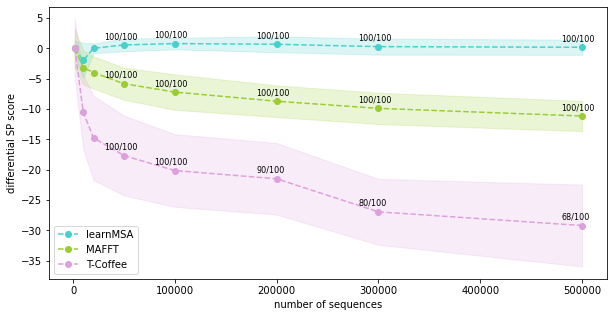

In [23]:
#filenames = ["PF00400.35", "PF00005.30", "PF07679.19", "PF00041.24", "PF00096.29", "PF00072.27"]

msa_method_keys = ["learnMSA", "mafft", "reg"]
msa_method_names = ["learnMSA", "MAFFT", "T-Coffee"]
msa_method_colors = ["mediumturquoise", "yellowgreen", "plum"] 

differential = True
treat_missing_as_zero_score = True

def get_avg(method, score_type = 0):
    results = load_results("results/size_scaling/"+method+".out")
    results_avg = []
    results_sd = []
    found = []
    for s in subset_sizes:
        scores = []
        f = 0
        for filename in filenames:
            scores.append([])
            for k in range(num_samples):
                key = f"{filename}_{s}_{k}"
                if key in results:
                    scores[-1].append(results[key][score_type])
                    f += 1
                elif treat_missing_as_zero_score:
                    scores[-1].append(0.)
        #mean and sd over samples
        avg = [np.mean(s) for s in scores]
        sd = [np.std(s) for s in scores]
        #average values over families
        results_avg.append(np.mean(avg))
        results_sd.append(np.mean(sd))
        found.append(f)
    if differential:
        results_avg = [x-results_avg[0] for x in results_avg]
    results_avg = np.array(results_avg)
    results_sd = np.array(results_sd)
    return results_avg, results_sd, found

total = num_samples*len(fasta_files)
for key, name, color in zip(msa_method_keys, msa_method_names, msa_method_colors):
    avg_scores, sd_scores, found = get_avg(key)
    plt.plot(subset_sizes, avg_scores, "--o", color=color, label=name)
    plt.fill_between(subset_sizes, avg_scores-2*sd_scores, avg_scores+2*sd_scores, color=color, alpha=.2)
    for x,y,f in list(zip(subset_sizes, avg_scores, found))[3:]:
        plt.annotate(f"{f}/{total}", (x-20000, y+1), fontsize=8)
    
plt.legend()
plt.xlabel("number of sequences")
if differential:
    plt.ylabel("differential SP score")
else:
    plt.ylabel("SP score")
plt.rcParams["figure.figsize"] = (10,5)
plt.savefig("fig/size_scaling.pdf", bbox_inches='tight')

Average differential SP scores of MSAs of increasing depths with respect to a shallow baseline MSA. Each data point is averaged over 10 protein families and another 10 randomly drawn sequence sets per family that are sampled as follows. First, $500.000$ member sequences of the respective protein family are drawn randomly. Thereupon in each step, random homologs are removed, i.e. the alignment depths is decreased such that the aligned subsets are nested, ending with a total number of $1500$ sequences, which we used to compute the baseline score. 